# Peter dan Serigala: Lingkungan yang Realistis

Dalam situasi kita, Peter dapat bergerak hampir tanpa merasa lelah atau lapar. Dalam dunia yang lebih realistis, dia harus duduk dan beristirahat dari waktu ke waktu, serta memberi makan dirinya sendiri. Mari kita buat dunia kita lebih realistis dengan menerapkan aturan-aturan berikut:

1. Dengan berpindah dari satu tempat ke tempat lain, Peter kehilangan **energi** dan mendapatkan sedikit **kelelahan**.
2. Peter dapat mendapatkan lebih banyak energi dengan memakan apel.
3. Peter dapat menghilangkan kelelahan dengan beristirahat di bawah pohon atau di atas rumput (yaitu berjalan ke lokasi papan yang memiliki pohon atau rumput - lapangan hijau).
4. Peter perlu menemukan dan membunuh serigala.
5. Untuk membunuh serigala, Peter harus memiliki tingkat energi dan kelelahan tertentu, jika tidak, dia akan kalah dalam pertempuran.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

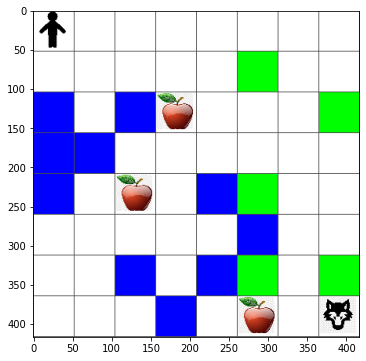

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Mendefinisikan state

Dalam aturan permainan baru kita, kita perlu melacak energi dan kelelahan di setiap keadaan papan. Oleh karena itu, kita akan membuat sebuah objek `state` yang akan membawa semua informasi yang diperlukan tentang keadaan masalah saat ini, termasuk keadaan papan, tingkat energi dan kelelahan saat ini, serta apakah kita bisa mengalahkan serigala saat berada di keadaan terminal:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

Mari kita coba menyelesaikan masalah menggunakan random walk dan lihat apakah kita berhasil:


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Fungsi Reward



In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Algoritma Q-Learning

Algoritma pembelajaran sebenarnya tetap hampir tidak berubah, kita hanya menggunakan `state` daripada hanya posisi papan.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

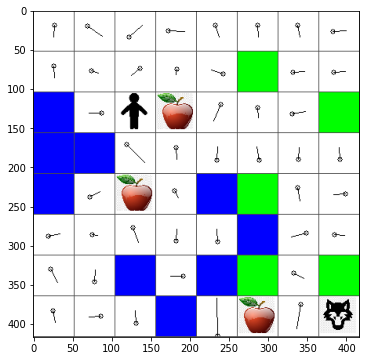

In [11]:
m.plot(Q)

## Hasil

Mari kita lihat apakah kita berhasil melatih Peter untuk melawan serigala!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Kami sekarang melihat jauh lebih sedikit kasus tenggelam, tetapi Peter masih belum selalu mampu membunuh serigala. Cobalah bereksperimen dan lihat apakah Anda dapat meningkatkan hasil ini dengan bermain-main dengan hiperparameter.


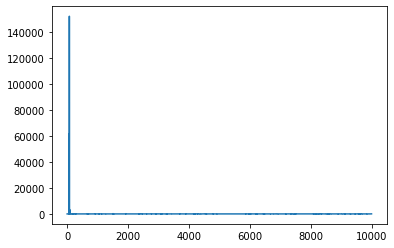

In [13]:
plt.plot(lpath)


---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan layanan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Meskipun kami berupaya untuk memberikan hasil yang akurat, harap diperhatikan bahwa terjemahan otomatis mungkin mengandung kesalahan atau ketidakakuratan. Dokumen asli dalam bahasa aslinya harus dianggap sebagai sumber yang berwenang. Untuk informasi yang bersifat kritis, disarankan menggunakan jasa terjemahan manusia profesional. Kami tidak bertanggung jawab atas kesalahpahaman atau penafsiran yang keliru yang timbul dari penggunaan terjemahan ini.
